In [23]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Data and Dataloaders

In [9]:
root = '/content/drive/MyDrive/data/pizza_steak_sushi/'
train_dir = root + 'train'
test_dir = root + 'test'

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform
)

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=32,
    num_workers=os.cpu_count(),
    shuffle=False
)


In [11]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### Create Model Architecture

In [13]:
class TinyVGG(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_dim*16*16, out_features=output_dim)
        )

    def forward(self, x):
        return self.classifier(self.cnn2(self.cnn1(x)))

### Create functions for train and test

In [15]:
def train_step(model, loader, loss_fn, optimizer, device):
    train_loss, train_acc = 0, 0
    model.train()
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)
        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc += (y_pred == y).sum().item() / len(y_pred)
    train_loss /= len(loader)
    train_acc /= len(loader)

    return train_loss, train_acc

def test_step(model, loader, loss_fn, device):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            test_acc += (y_pred == y).sum().item() / len(y_pred)
        test_loss /= len(loader)
        test_acc /= len(loader)

    return test_loss, test_acc

def train(model, train_loader, test_loader, loss_fn, optimizer, device = device, epochs = 5):
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_loader, loss_fn, optimizer, device=device)
        test_loss, test_acc = test_step(model, test_loader, loss_fn, device=device)
        print(f'Epoch: {epoch+1} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    results = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_loss': test_losses,
        'test_acc': test_accs
    }
    return results

### Train model

In [16]:
num_epochs = [5, 20, 50]

total_model_results = {
    '5 epochs': None,
    '20 epochs': None,
    '50 epochs': None
}

for epochs in num_epochs:
    model = TinyVGG(input_dim=3, hidden_dim=10, output_dim=len(class_names)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params=model.parameters(), lr=0.001)
    print(f'Training model for {epochs} epochs...')
    model_results = train(model, train_loader, test_loader, loss_fn, optimizer, device, epochs)
    epoch_string = f'{epochs} epochs:'
    total_model_results[epoch_string] = model_results

Training model for 5 epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1018 | Train acc: 0.2930 | Test loss: 1.1069 | Test acc: 0.1979
Epoch: 2 | Train loss: 1.0960 | Train acc: 0.4141 | Test loss: 1.1079 | Test acc: 0.1979
Epoch: 3 | Train loss: 1.1018 | Train acc: 0.2930 | Test loss: 1.1065 | Test acc: 0.1979
Epoch: 4 | Train loss: 1.0957 | Train acc: 0.4141 | Test loss: 1.1075 | Test acc: 0.1979
Epoch: 5 | Train loss: 1.1020 | Train acc: 0.2930 | Test loss: 1.1061 | Test acc: 0.1979
Training model for 20 epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0961 | Train acc: 0.4023 | Test loss: 1.0878 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.1018 | Train acc: 0.2812 | Test loss: 1.0888 | Test acc: 0.5417
Epoch: 3 | Train loss: 1.0974 | Train acc: 0.4023 | Test loss: 1.0876 | Test acc: 0.5417
Epoch: 4 | Train loss: 1.1010 | Train acc: 0.2812 | Test loss: 1.0887 | Test acc: 0.5417
Epoch: 5 | Train loss: 1.0997 | Train acc: 0.2773 | Test loss: 1.0898 | Test acc: 0.5417
Epoch: 6 | Train loss: 1.1020 | Train acc: 0.2734 | Test loss: 1.0912 | Test acc: 0.5625
Epoch: 7 | Train loss: 1.0962 | Train acc: 0.4023 | Test loss: 1.0900 | Test acc: 0.5521
Epoch: 8 | Train loss: 1.0958 | Train acc: 0.4062 | Test loss: 1.0888 | Test acc: 0.5521
Epoch: 9 | Train loss: 1.1011 | Train acc: 0.2812 | Test loss: 1.0902 | Test acc: 0.5521
Epoch: 10 | Train loss: 1.0997 | Train acc: 0.2812 | Test loss: 1.0913 | Test acc: 0.5625
Epoch: 11 | Train loss: 1.0993 | Train acc: 0.2695 | Test loss: 1.0923 | Test acc: 0.4820
Epoch: 12 | Train l

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.1054 | Train acc: 0.2930 | Test loss: 1.0980 | Test acc: 0.1979
Epoch: 2 | Train loss: 1.1045 | Train acc: 0.2930 | Test loss: 1.0984 | Test acc: 0.1979
Epoch: 3 | Train loss: 1.0986 | Train acc: 0.2930 | Test loss: 1.0976 | Test acc: 0.1979
Epoch: 4 | Train loss: 1.1036 | Train acc: 0.2930 | Test loss: 1.0979 | Test acc: 0.1979
Epoch: 5 | Train loss: 1.0963 | Train acc: 0.4141 | Test loss: 1.0987 | Test acc: 0.1979
Epoch: 6 | Train loss: 1.0988 | Train acc: 0.2930 | Test loss: 1.0979 | Test acc: 0.1979
Epoch: 7 | Train loss: 1.0963 | Train acc: 0.4141 | Test loss: 1.0987 | Test acc: 0.1979
Epoch: 8 | Train loss: 1.1037 | Train acc: 0.2930 | Test loss: 1.0990 | Test acc: 0.1979
Epoch: 9 | Train loss: 1.0987 | Train acc: 0.2930 | Test loss: 1.0982 | Test acc: 0.1979
Epoch: 10 | Train loss: 1.0986 | Train acc: 0.2930 | Test loss: 1.0974 | Test acc: 0.1979
Epoch: 11 | Train loss: 1.0983 | Train acc: 0.2930 | Test loss: 1.0966 | Test acc: 0.1979
Epoch: 12 | Train l

In [18]:
epoch5df = pd.DataFrame(total_model_results['5 epochs:'])
epoch20df = pd.DataFrame(total_model_results['20 epochs:'])
epoch50df = pd.DataFrame(total_model_results['50 epochs:'])

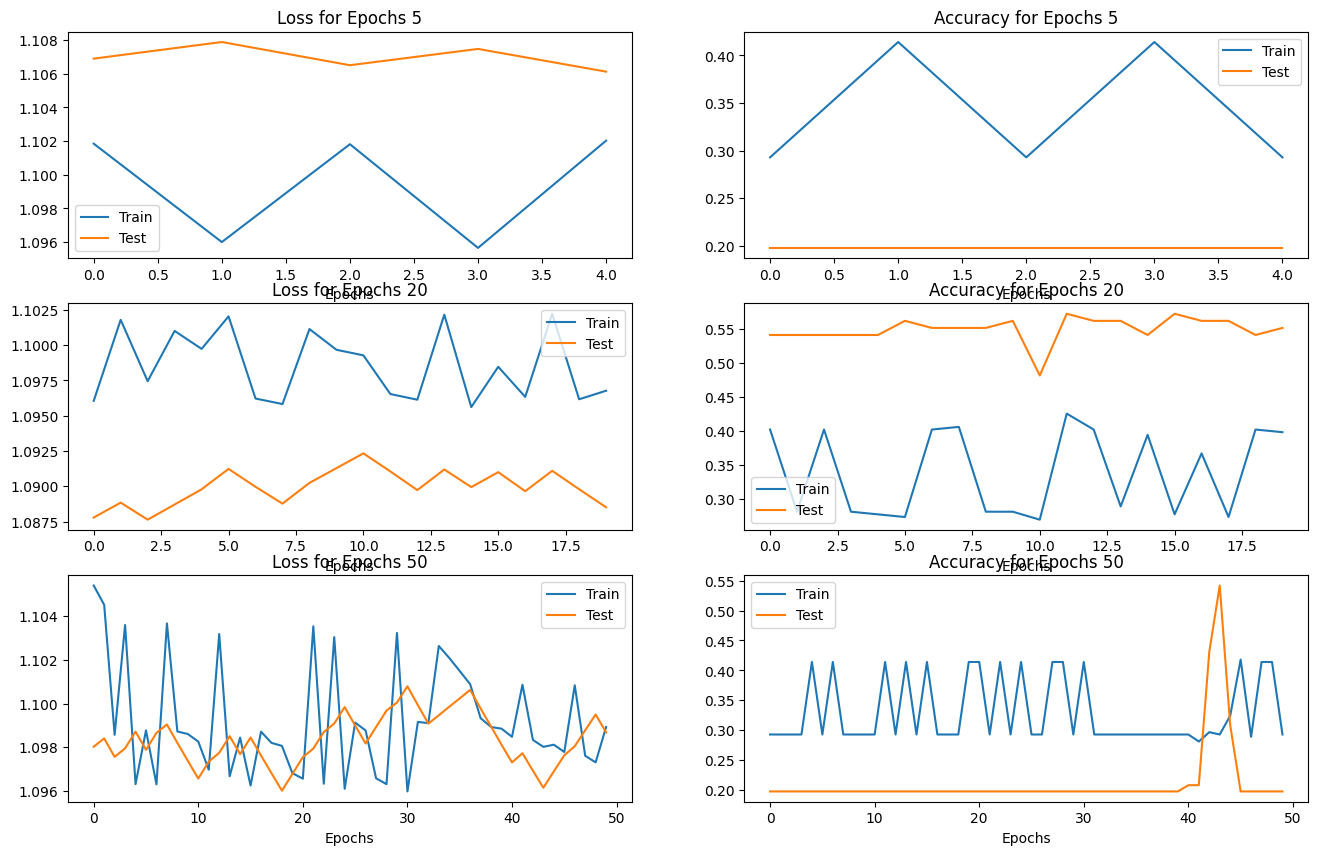

In [20]:
plt.figure(figsize = (16, 10))
epochs = range(len(epoch5df))
plt.subplot(3, 2, 1)
plt.plot(epochs, epoch5df['train_loss'], label = 'Train')
plt.plot(epochs, epoch5df['test_loss'], label = 'Test')
plt.title('Loss for Epochs 5')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, epoch5df['train_acc'], label = 'Train')
plt.plot(epochs, epoch5df['test_acc'], label = 'Test')
plt.title('Accuracy for Epochs 5')
plt.xlabel('Epochs')
plt.legend()

epochs = range(len(epoch20df))
plt.subplot(3, 2, 3)
plt.plot(epochs, epoch20df['train_loss'], label = 'Train')
plt.plot(epochs, epoch20df['test_loss'], label = 'Test')
plt.title('Loss for Epochs 20')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, epoch20df['train_acc'], label = 'Train')
plt.plot(epochs, epoch20df['test_acc'], label = 'Test')
plt.title('Accuracy for Epochs 20')
plt.xlabel('Epochs')
plt.legend()

epochs = range(len(epoch50df))
plt.subplot(3, 2, 5)
plt.plot(epochs, epoch50df['train_loss'], label = 'Train')
plt.plot(epochs, epoch50df['test_loss'], label = 'Test')
plt.title('Loss for Epochs 50')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs, epoch50df['train_acc'], label = 'Train')
plt.plot(epochs, epoch50df['test_acc'], label = 'Test')
plt.title('Accuracy for Epochs 50')
plt.xlabel('Epochs')
plt.legend()

### Modifications

#### Double hidden layers and train 20 epochs

In [21]:
model = TinyVGG(input_dim=3, hidden_dim=20, output_dim=len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.001)
print(f'Training model for {epochs} epochs...')
model_results = train(model, train_loader, test_loader, loss_fn, optimizer, device, 20)

Training model for range(0, 50) epochs...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Train loss: 1.0981 | Train acc: 0.3047 | Test loss: 1.1051 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.1011 | Train acc: 0.3047 | Test loss: 1.1030 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1006 | Train acc: 0.3047 | Test loss: 1.1009 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0954 | Train acc: 0.4258 | Test loss: 1.1019 | Test acc: 0.2604
Epoch: 5 | Train loss: 1.0994 | Train acc: 0.3047 | Test loss: 1.1033 | Test acc: 0.2604
Epoch: 6 | Train loss: 1.0946 | Train acc: 0.4258 | Test loss: 1.1043 | Test acc: 0.2604
Epoch: 7 | Train loss: 1.0935 | Train acc: 0.4258 | Test loss: 1.1053 | Test acc: 0.2604
Epoch: 8 | Train loss: 1.0927 | Train acc: 0.4258 | Test loss: 1.1062 | Test acc: 0.2604
Epoch: 9 | Train loss: 1.0923 | Train acc: 0.4258 | Test loss: 1.1071 | Test acc: 0.2604
Epoch: 10 | Train loss: 1.0996 | Train acc: 0.3047 | Test loss: 1.1084 | Test acc: 0.2604
Epoch: 11 | Train loss: 1.0915 | Train acc: 0.4258 | Test loss: 1.1093 | Test acc: 0.2604
Epoch: 12 | Train l

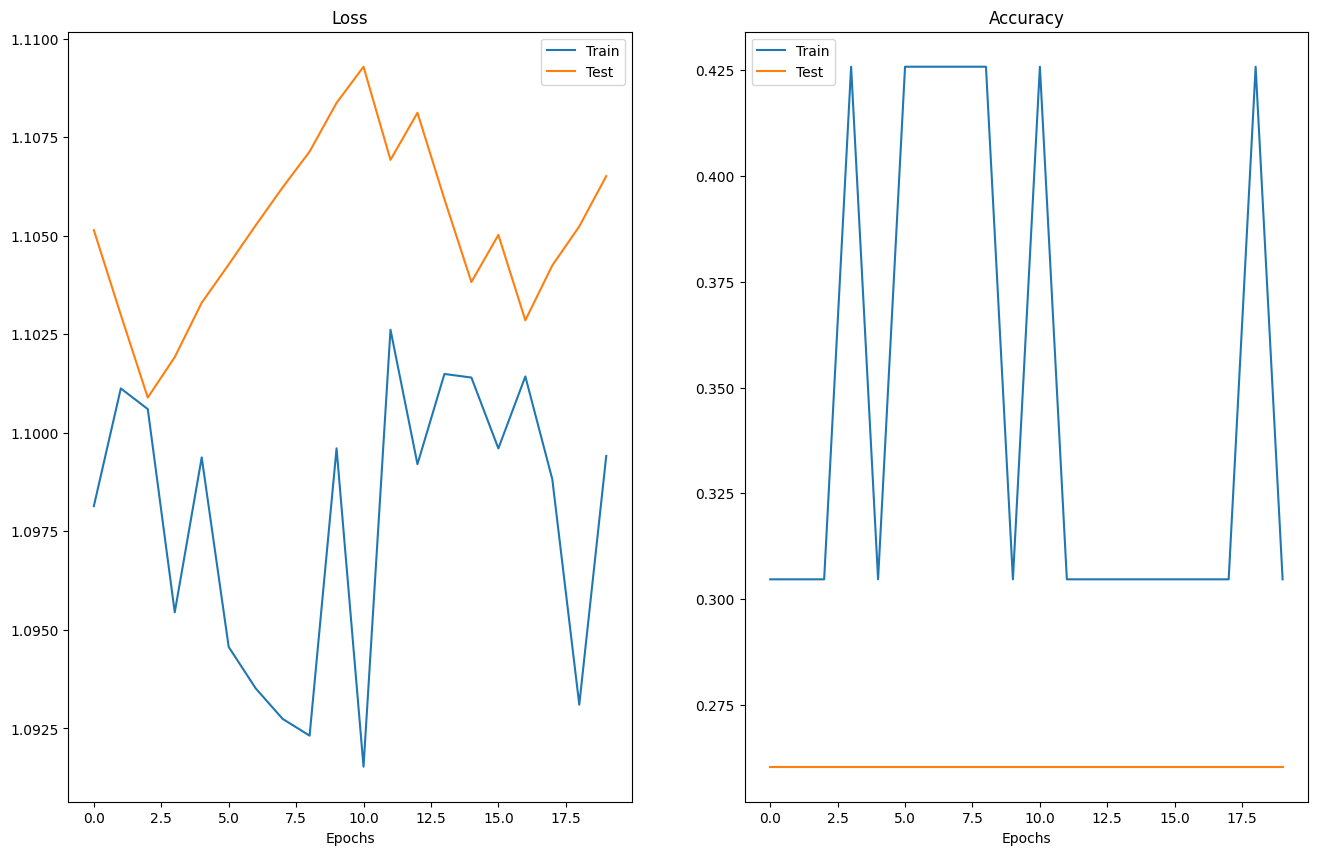

In [22]:
plt.figure(figsize = (16, 10))
epochs = range(len(model_results['train_loss']))
plt.subplot(1, 2, 1)
plt.plot(epochs, model_results['train_loss'], label = 'Train')
plt.plot(epochs, model_results['test_loss'], label = 'Test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, model_results['train_acc'], label = 'Train')
plt.plot(epochs, model_results['test_acc'], label = 'Test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()

### Make Predictions

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(-0.5, 63.5, 63.5, -0.5)

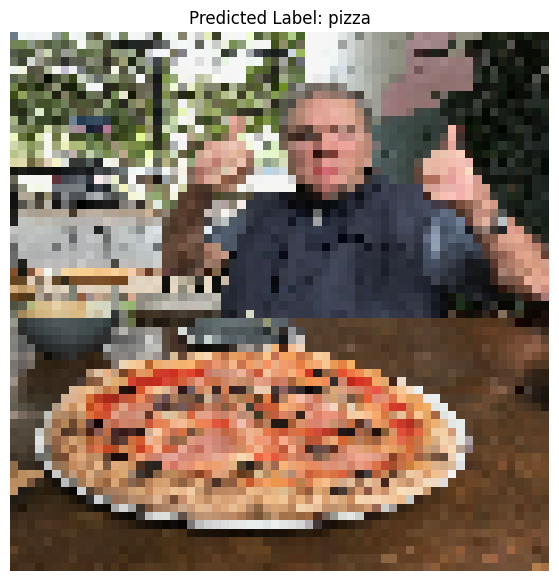

In [28]:
test_img_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])
test_img_dir = '/content/drive/MyDrive/data/04-pizza-dad.jpeg'
test_img = torchvision.io.read_image(str(test_img_dir)).type(torch.float32)
test_img /= 255.
test_img = test_img_transform(test_img)

model.eval()
with torch.inference_mode():
  y_logits = model(test_img.unsqueeze(dim=0).to(device))
  y_pred_label = torch.softmax(y_logits, dim=1).argmax(dim=1)
  y_pred_class = class_names[y_pred_label]

plt.figure(figsize = (10, 7))
plt.imshow(test_img.permute(1, 2, 0))
plt.title(f'Predicted Label: {y_pred_class}')
plt.axis(False)